# Libraries

In [1]:
# google colaboratory setup script
%%bash
pip install -q datasets
pip install -q wandb
pip install -q transformers[torch]
pip install -q accelerate -U
mkdir -p dev/trl
git clone https://github.com/huggingface/trl.git dev/trl
rm -f dev/trl/trl/trainer/dpo_trainer.py && cp dpo_trainer.py dev/trl/trl/trainer/
pip install -e dev/trl/ --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.6 MB/s eta 0:00:00


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, GenerationConfig
import torch
from datasets import load_dataset, Dataset

from dataclasses import dataclass, field
from typing import Dict, Optional

from transformers import HfArgumentParser, TrainingArguments

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import entropy
from collections import defaultdict

import wandb
wandb.login()

wandb: Currently logged in as: acko (acko_team). Use `wandb login --relogin` to force relogin


True

In [1]:
from trl import DPOTrainer
from trl.core import LengthSampler

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# inference configs and funcs
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)


generation_config = GenerationConfig(
    min_length=-1,
    top_k=5,
    top_p=1.0,
    do_sample=True,
)

def generate(text, new_tokens, model):
    """
    Generate new text of a given length given a prompt.
    Args: 
        text: str, prompt
        new_tokens: int, number of tokens to generate
        model: model to use for generation
    Returns: 
        str, generated text
    """
    input_ids = tokenizer(text, return_tensors='pt').to(device)
    output_tokens = model.generate(**input_ids,
                                   max_new_tokens=new_tokens,
                                   generation_config=generation_config,
                                   pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    return text


def classify(text):
    """
    Classify text as positive or negative.
    Args: 
        text: str, text to classify
    Returns:
        predicted_class_id: int, 0 or 1
        logits: torch.tensor, logits for each class
    """
    inputs = bert_tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = bert_model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id, logits


def model_inspection(loss_type: 'str'):
    """
    Generate text with both models and compare the rewards.
    Args: 
        loss_type: str, loss function to use
    Returns:
        None
    """
    for prompt in tqdm(range(len(dataset_sample))):
        text = dataset_sample['prompt'][prompt]
        # ref model
        output_before = generate(text,
                                new_tokens=output_length_sampler(),
                                model=model_ref)
        rewards_before = classify(output_before)

        # dpo model
        output_after = generate(text, new_tokens=output_length_sampler(), model=model)
        rewards_after = classify(output_after)
        temp = pd.DataFrame({"loss_type": loss_type,
                            "prompt": [text],
                            "output_before": output_before,
                            "output_after": output_after,
                            "rewards_before": [float(rewards_before[1][0,1])],
                            "rewards_after": [float(rewards_after[1][0,1])],
                            })
        global df_comparison
        df_comparison = pd.concat([df_comparison, temp], ignore_index=True)


# diversity
def token_entropy(generations, tokenizer):
    """
    Calculate entropy of tokens in generated text.
    Args: 
        generations: list of str, generated text
        tokenizer: tokenizer
    Returns:
        float, entropy of tokens
    """
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens
    return entropy(list(stats.values()))


# Level 0

## Load models

In [8]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)

bert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
bert_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb").to(device)

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Prepare dataset

In [ ]:
# сниппет взят из примера trl https://huggingface.co/docs/trl/sentiment_tuning
def build_dataset(model="lvwerra/gpt2-imdb", dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.
    Args:
        dataset_name (`str`): The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`): The dataloader for the dataset.
    """
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [ ]:
dataset = build_dataset()
dataset = dataset.train_test_split(train_size=0.2, seed=42)
dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'query'],
        num_rows: 4979
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'query'],
        num_rows: 19916
    })
})

In [ ]:
reward_dataset = pd.DataFrame(columns=["prompt", "output", "score"])

In [ ]:
# generate samples
for prompt in tqdm(range(len(dataset['train']))):
    text = dataset['train']['query'][prompt]
    for _ in range(3):
        # get inference from gpt2
        output = generate(text, output_length_sampler(), model)
        # compute sentiment
        sentiment = classify(output)
        # write up into df
        temp = pd.DataFrame(
            {
                "prompt": [text],
                "output": [output],
                "score": [float(sentiment[1][0,1])],
                }
            )
        reward_dataset = pd.concat([reward_dataset, temp], ignore_index=True)

100%|██████████| 4979/4979 [35:15<00:00,  2.35it/s]


## Create DOP win-lose dataset

In [ ]:
df = reward_dataset.copy()
group_labels = np.arange(len(df)) // 3
max_index = df['score'].groupby(group_labels).idxmax()
min_index = df['score'].groupby(group_labels).idxmin()

In [ ]:
df1 = pd.DataFrame(columns=["prompt", "chosen", "rejected"])

In [ ]:
df1['prompt'] = df.iloc[max_index.values, 0].values
df1['chosen'] = df.iloc[max_index.values, 1].values
df1['rejected'] = df.iloc[min_index.values, 1].values

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4979 entries, 0 to 4978
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    4979 non-null   object
 1   chosen    4979 non-null   object
 2   rejected  4979 non-null   object
dtypes: object(3)
memory usage: 116.8+ KB


In [ ]:
df1.head()

,prompt,chosen,rejected
0,I was so,I was so impressed. I have to say I am very im...,I was so impressed by the film that I went to the
1,A few months,"A few months later, he was back on","A few months later, I found out that the"
2,"""Soylent Green","""Soylent Green"" (1936) was a very good film, a...","""Soylent Green"" is a movie that's not just goo..."
3,This is,This is one of the most,This is a movie with no story and no action.
4,Like Freddy's,Like Freddy's Revenge is one of the few good h...,Like Freddy's Nightmare on Elm Street is


In [ ]:
# push to the hub
dataset = Dataset.from_pandas(df1)
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
dataset.push_to_hub("9ikloj/dpo_imdb")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/466 [00:00<?, ?B/s]

# Level 1

## DPO Trainer Hinge Loss

### Training

In [6]:
dataset = load_dataset("9ikloj/dpo_imdb")
train_dataset = dataset['train']
eval_dataset = dataset['test']

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3983 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/996 [00:00<?, ? examples/s]

In [13]:
wandb.init(project="optim_dpo", name="hinge")

In [8]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
model_ref = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
tokenizer.pad_token = tokenizer.eos_token

bert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
bert_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb").to(device)

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [12]:
training_args = TrainingArguments(
        remove_unused_columns=False,
        evaluation_strategy="steps",
        logging_first_step=True,
        logging_steps=50,  # match results in blog post
        eval_steps=500,
        output_dir="./test",
        learning_rate=1e-6,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        max_steps=1000,
        gradient_checkpointing=False,
        optim="adamw_torch",
        warmup_steps=150,
        report_to='wandb',
        bf16=False,
        # TODO: uncomment that on the next transformers release
    )


dpo_trainer = DPOTrainer(
    model,
    model_ref,
    args=training_args,
    beta=0.1,
    loss_type="hinge",
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    max_length=200,
    max_prompt_length=30,
    max_target_length=130,
    generate_during_eval=True,
)

In [14]:
dpo_trainer.train()

Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
500,0.910000,0.902419,0.065970,-0.031729,0.826000,0.097699,-52.129601,-51.323868,-38.655754,-38.405811
1000,0.853900,0.858867,0.077754,-0.063454,0.831000,0.141209,-52.446861,-51.206032,-38.693615,-38.513988


TrainOutput(global_step=1000, training_loss=0.9126894239187241, metrics={'train_runtime': 203.8039, 'train_samples_per_second': 19.627, 'train_steps_per_second': 4.907, 'total_flos': 0.0, 'train_loss': 0.9126894239187241, 'epoch': 1.0})

In [15]:
wandb.finish()

eval/logits/chosen,█▁
eval/logits/rejected,█▁
eval/logps/chosen,▁█
eval/logps/rejected,█▁
eval/loss,█▁
eval/rewards/accuracies,▁█
eval/rewards/chosen,▁█
eval/rewards/margins,▁█
eval/rewards/rejected,█▁
eval/runtime,█▁
eval/samples_per_second,▁█


### Model Inspection

In [21]:
df_comparison = pd.DataFrame(columns=["loss_type",
                                      "prompt",
                                      "output_before",
                                      "output_after",
                                      "rewards_before",
                                      "rewards_after"])

In [22]:
dataset_sample = dataset['train'].train_test_split(train_size = 0.063, seed=42)
dataset_sample = dataset_sample['train']
dataset_sample

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 250
})

In [23]:
model_inspection('hinge')

100%|██████████| 250/250 [01:27<00:00,  2.85it/s]


## DPO Trainer Sigmoid Loss

### Training

In [26]:
wandb.init(project="optim_dpo", name="sigmoid")

In [27]:
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
model_ref = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)

In [28]:
training_args = TrainingArguments(
        remove_unused_columns=False,
        evaluation_strategy="steps",
        logging_first_step=True,
        logging_steps=50,  # match results in blog post
        eval_steps=500,
        output_dir="./test",
        learning_rate=1e-6,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        max_steps=1000,
        gradient_checkpointing=False,
        optim="adamw_torch",
        warmup_steps=150,
        report_to='wandb',
        bf16=False,
        # TODO: uncomment that on the next transformers release
    )


dpo_trainer = DPOTrainer(
    model,
    model_ref,
    args=training_args,
    beta=0.1,
    loss_type="sigmoid",
    label_smoothing=0, # no regularization
    debug=False,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    max_length=200,
    max_prompt_length=30,
    max_target_length=130,
    generate_during_eval=True,
)

In [29]:
dpo_trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
500,0.651100,0.648020,0.065387,-0.030089,0.828000,0.095476,-52.113205,-51.329704,-38.667114,-38.414791
1000,0.627500,0.629833,0.077542,-0.059377,0.833000,0.136919,-52.406082,-51.208153,-38.706127,-38.521042


TrainOutput(global_step=1000, training_loss=0.653073079586029, metrics={'train_runtime': 196.3862, 'train_samples_per_second': 20.368, 'train_steps_per_second': 5.092, 'total_flos': 0.0, 'train_loss': 0.653073079586029, 'epoch': 1.0})

In [30]:
wandb.finish()

eval/logits/chosen,█▁
eval/logits/rejected,█▁
eval/logps/chosen,▁█
eval/logps/rejected,█▁
eval/loss,█▁
eval/rewards/accuracies,▁█
eval/rewards/chosen,▁█
eval/rewards/margins,▁█
eval/rewards/rejected,█▁
eval/runtime,█▁
eval/samples_per_second,▁█


### Model Inspection

In [31]:
model_inspection('sigmoid')

100%|██████████| 250/250 [01:17<00:00,  3.24it/s]


## DPO Trainer Sigmoid Regularized

### Training

In [32]:
wandb.init(project="optim_dpo", name="sigmoid_reg")

In [33]:
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
model_ref = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)

In [34]:
training_args = TrainingArguments(
        remove_unused_columns=False,
        evaluation_strategy="steps",
        logging_first_step=True,
        logging_steps=50,  # match results in blog post
        eval_steps=500,
        output_dir="./test",
        learning_rate=1e-6,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        max_steps=1000,
        gradient_checkpointing=False,
        optim="adamw_torch",
        warmup_steps=150,
        report_to='wandb',
        bf16=False,
        # TODO: uncomment that on the next transformers release
    )


dpo_trainer = DPOTrainer(
    model,
    model_ref,
    args=training_args,
    beta=0.1,
    loss_type="sigmoid",
    label_smoothing=0.3, # robust parameter
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

    tokenizer=tokenizer,
    max_length=200,
    max_prompt_length=30,
    max_target_length=130,
    generate_during_eval=True,
)

In [35]:
dpo_trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
500,0.677900,0.677035,0.064197,-0.028412,0.831000,0.092609,-52.096428,-51.341610,-38.681656,-38.426117
1000,0.670900,0.671669,0.076304,-0.054082,0.839000,0.130386,-52.353130,-51.220531,-38.719650,-38.525551


TrainOutput(global_step=1000, training_loss=0.6789885268211365, metrics={'train_runtime': 196.7437, 'train_samples_per_second': 20.331, 'train_steps_per_second': 5.083, 'total_flos': 0.0, 'train_loss': 0.6789885268211365, 'epoch': 1.0})

In [36]:
wandb.finish()

eval/logits/chosen,█▁
eval/logits/rejected,█▁
eval/logps/chosen,▁█
eval/logps/rejected,█▁
eval/loss,█▁
eval/rewards/accuracies,▁█
eval/rewards/chosen,▁█
eval/rewards/margins,▁█
eval/rewards/rejected,█▁
eval/runtime,█▁
eval/samples_per_second,▁█


### Model Inspection

In [37]:
model_inspection('sigmoid_reg')

100%|██████████| 250/250 [01:35<00:00,  2.61it/s]


## Results

In [38]:
df_hinge = df_comparison[df_comparison['loss_type'] == 'hinge']
df_sig = df_comparison[df_comparison['loss_type'] == 'sigmoid']
df_sigr = df_comparison[df_comparison['loss_type'] == 'sigmoid_reg']

In [39]:
df_hinge.describe()

,rewards_before,rewards_after
count,250.000000,250.000000
mean,0.573016,1.362415
std,1.746393,1.400427
min,-3.079534,-2.881706
25%,-0.778918,0.444661
50%,1.052616,1.693110
75%,2.000675,2.561731
max,2.901366,2.901190


In [40]:
df_sig.describe()

,rewards_before,rewards_after
count,250.000000,250.000000
mean,0.546341,1.425700
std,1.730927,1.472610
min,-3.013844,-2.895533
25%,-0.804110,0.619435
50%,0.846170,1.881348
75%,2.130381,2.611176
max,2.872810,2.925032


In [41]:
df_sigr.describe()

,rewards_before,rewards_after
count,250.000000,250.000000
mean,0.597591,1.437749
std,1.632705,1.400379
min,-3.060110,-2.895533
25%,-0.521368,0.583245
50%,0.872179,1.887639
75%,1.889212,2.592538
max,2.910088,2.921042


In [45]:
# after dpo
div_hinge = token_entropy(df_hinge['output_after'].values, tokenizer)
div_sig = token_entropy(df_sig['output_after'].values, tokenizer)
div_sigr = token_entropy(df_sigr['output_after'].values, tokenizer)
# before dpo
div_orig = token_entropy(df_hinge['output_before'].values, tokenizer)

print(f" \
DPO Hinge loss diversity: {div_hinge:.4f}\n \
DPO Sigmo loss diversity: {div_sig:.4f}\n \
DPO Sigmr loss diversity: {div_sigr:.4f}\n \
Original model diversity: {div_orig:.4f}")

 DPO Hinge loss diversity: 5.4779
 DPO Sigmo loss diversity: 5.4716
 DPO Sigmr loss diversity: 5.4658
 Original model diversity: 5.5651


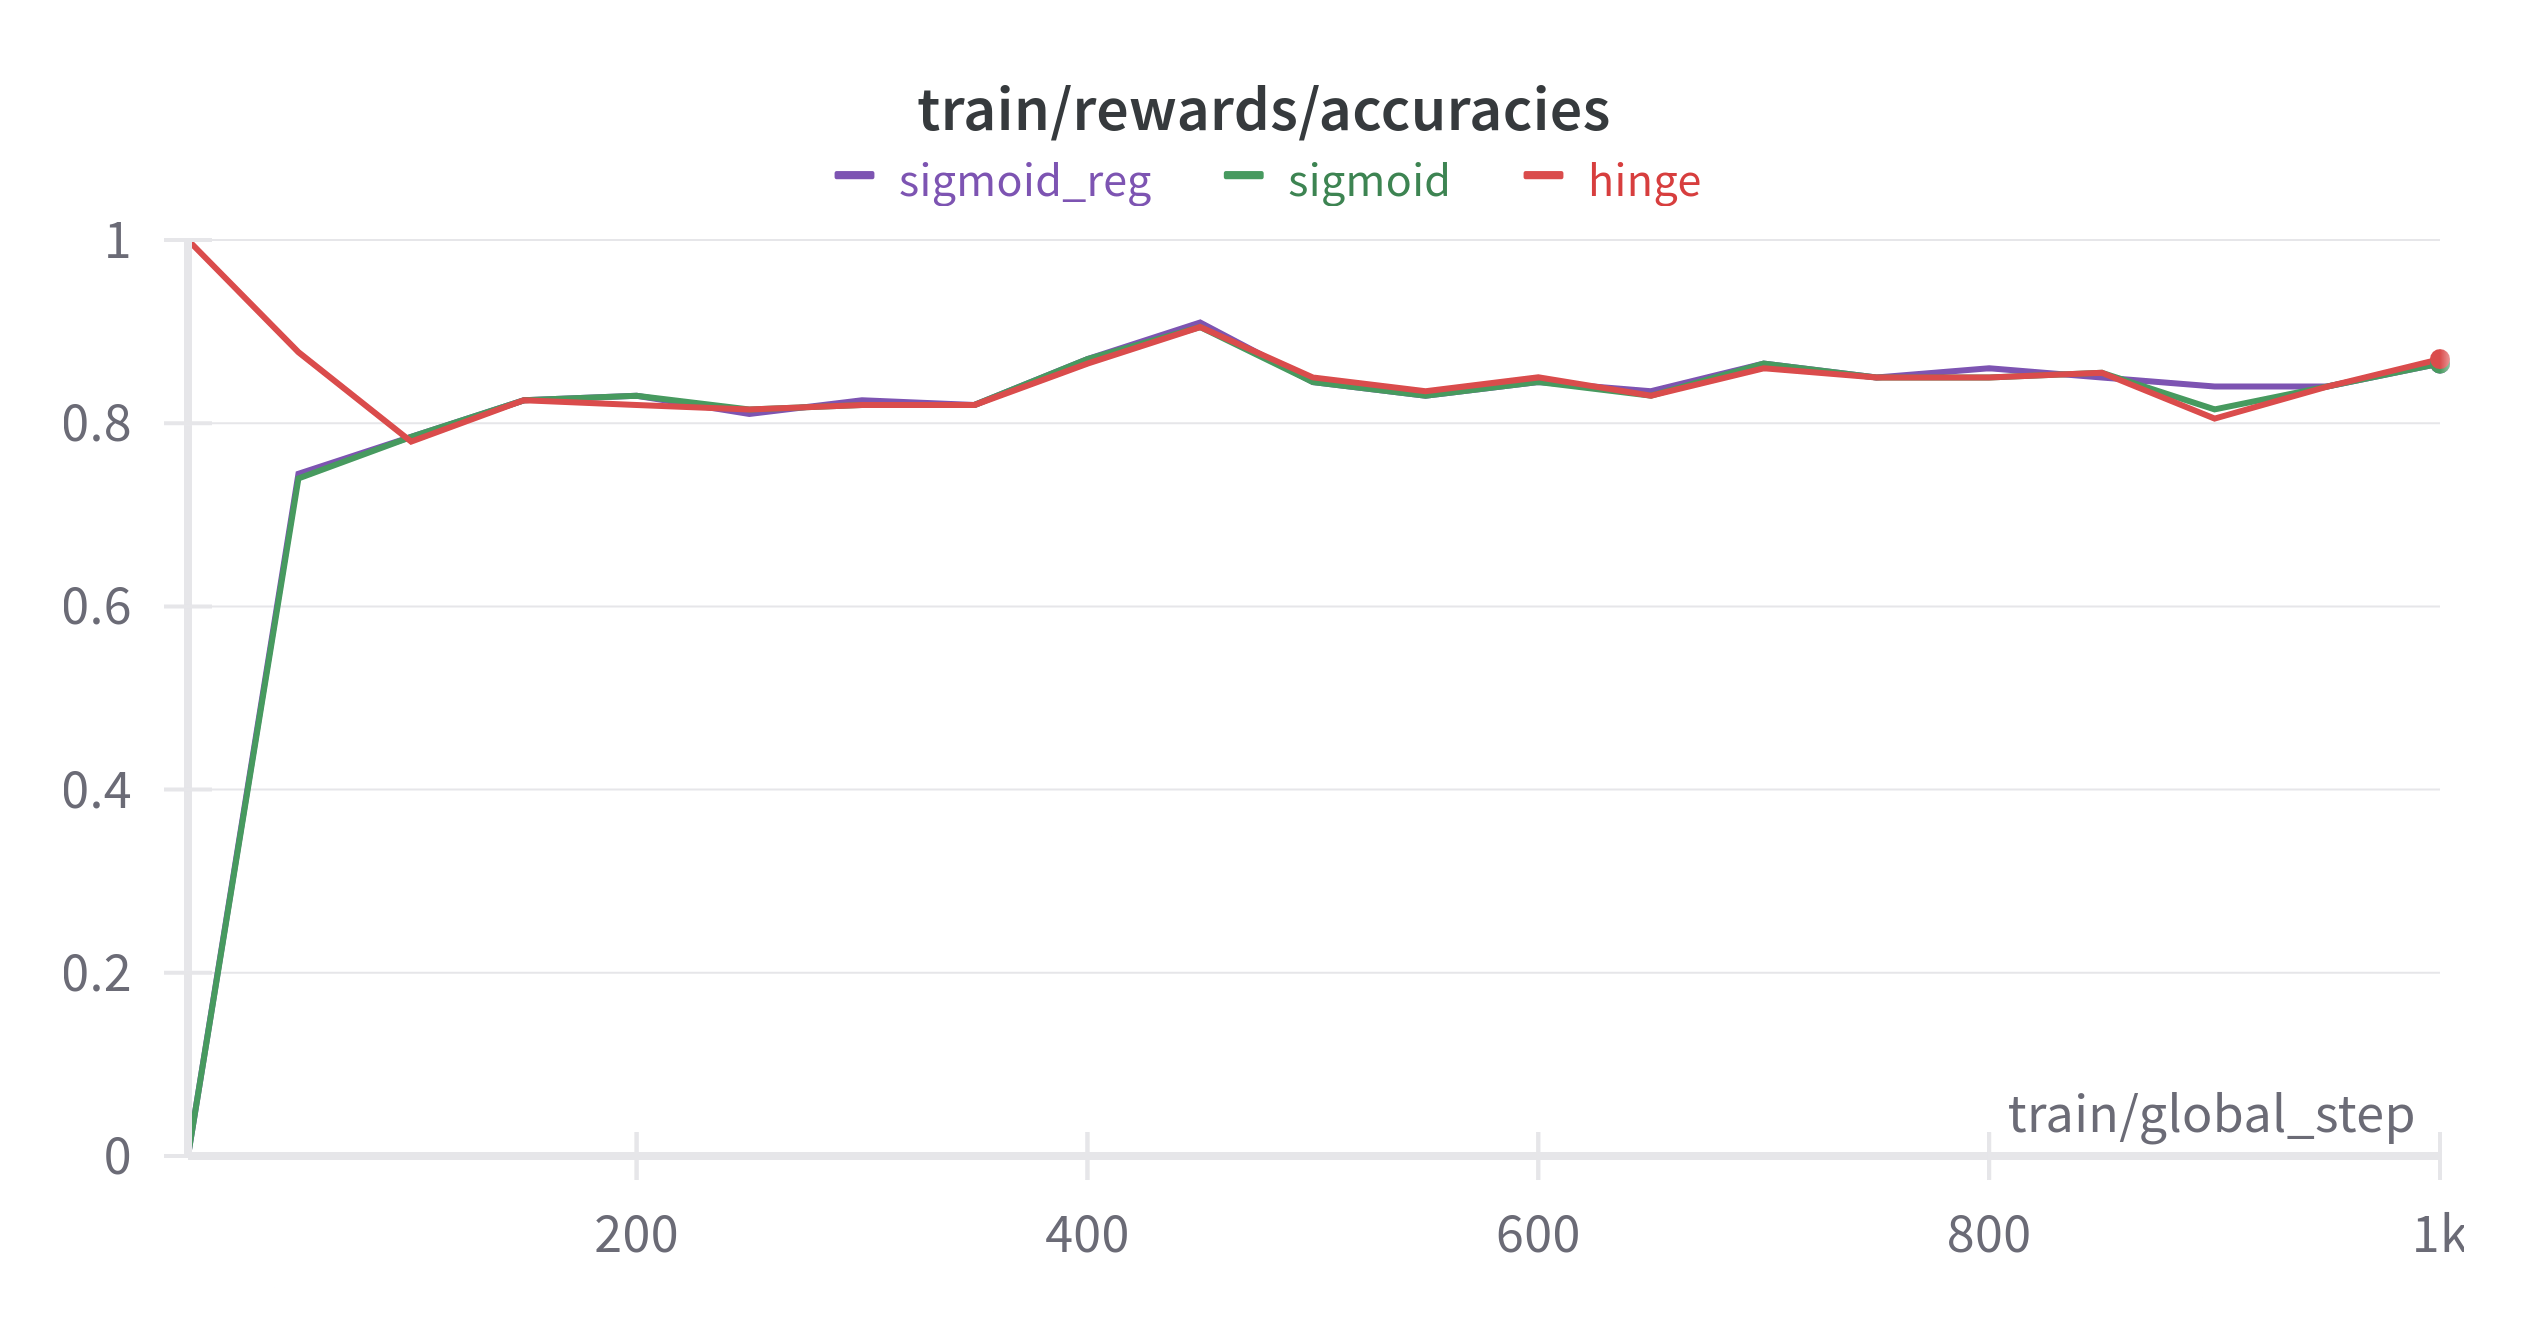

diversity/reward trade off получился почти идентичным для всех трех попыток.

# Level 2

## DPO f-divergence implementation
<strong>Оригинальная лосс-функция из статьи Рафаилова</strong><br>
<br>


\begin{equation}
\mathcal{L}_{DPO}(\pi_{\theta}; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma(\beta \log \frac{\pi_{\theta}(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_{\theta}(y_l | x)}{\pi_{\text{ref}}(y_l | x)}) \right]
\end{equation}
<br>

<strong>Обобщенная лосс-функция для класса f-дивергенций</strong>:<br>
<br>


\begin{equation}
\mathcal{L}(\theta, D) = \mathbb{E}_{(x, y_w, y_l) \sim D} \left[ -\log \sigma \left( \beta f' \left( \frac{\pi_{\theta}(y_w | x)}{\pi_{\text{ref}}(y_w | x)} \right) - \beta f' \left( \frac{\pi_{\theta}(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right) \right]
\end{equation}
<br>

Где f-divergence определяется в зависимости от значения α:<br>
<br>

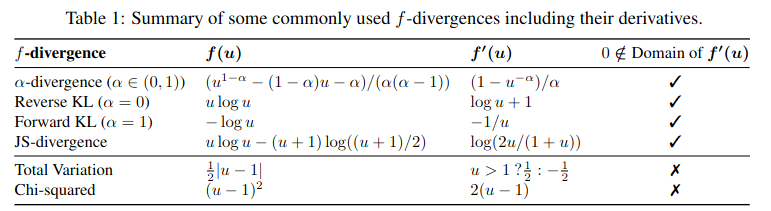
<br>



Также необходимо изменить подсчет rewards, в соответствии со статьей:<br>
<br>


\begin{equation}
r(y|x) = \beta f' \frac{\pi^*(y|x)}{\pi^{ref}(y|x)} + \text{const.}
\end{equation}
<br>

<strong>Ниже я попытался имплементировать forward KL в функцию dpo_loss() из скрипта dpo_trainer.py:</strong>
<br>

```python

# calculate loss
pi_logratios = torch.exp(pi_logratios)
ref_logratios = torch.exp(ref_logratios)

losses = -F.logsigmoid(self.beta *  (- (ref_logratios - pi_logratios)/ (pi_logratios * ref_logratios + epsilon)))

# calculate reward
chosen_rewards = self.beta * ( - torch.exp(reference_chosen_logps) / (torch.exp(policy_chosen_logps) + epsilon)).detach()
rejected_rewards = self.beta * ( - torch.exp(reference_rejected_logps) / (torch.exp(policy_rejected_logps) + epsilon)).detach()
```



### Training

In [5]:
dataset = load_dataset("9ikloj/dpo_imdb")
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [6]:
wandb.init(project="optim_dpo", name="fkl")

In [7]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
model_ref = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb").to(device)
tokenizer.pad_token = tokenizer.eos_token

bert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
bert_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb").to(device)

In [8]:
training_args = TrainingArguments(
        remove_unused_columns=False,
        evaluation_strategy="steps",
        logging_first_step=True,
        logging_steps=50,  # match results in blog post
        eval_steps=500,
        output_dir="./test",
        learning_rate=1e-6,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        max_steps=1000,
        gradient_checkpointing=False,
        optim="adamw_torch",
        warmup_steps=150,
        report_to='wandb',
        bf16=False,
        # TODO: uncomment that on the next transformers release
    )


dpo_trainer = DPOTrainer(
    model,
    model_ref,
    args=training_args,
    beta=0.1,
    loss_type="fkl",
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    max_length=200,
    max_prompt_length=30,
    max_target_length=130,
    generate_during_eval=True,
)

In [9]:
dpo_trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
500,1.403200,1.576818,-0.000353,-0.000345,0.511000,-0.000008,-51.646496,-51.367271,-39.560490,-39.231415
1000,1.020000,1.969295,-0.000367,-0.000370,0.511000,0.000003,-51.578384,-51.156048,-39.898571,-39.596321


TrainOutput(global_step=1000, training_loss=1.2671526484489442, metrics={'train_runtime': 205.3132, 'train_samples_per_second': 19.482, 'train_steps_per_second': 4.871, 'total_flos': 0.0, 'train_loss': 1.2671526484489442, 'epoch': 1.0})

In [10]:
wandb.finish()

eval/logits/chosen,█▁
eval/logits/rejected,█▁
eval/logps/chosen,▁█
eval/logps/rejected,▁█
eval/loss,▁█
eval/rewards/accuracies,▁▁
eval/rewards/chosen,█▁
eval/rewards/margins,▁█
eval/rewards/rejected,█▁
eval/runtime,█▁
eval/samples_per_second,▁█


### Model Inspection

In [11]:
df_comparison = pd.DataFrame(columns=["loss_type",
                                      "prompt",
                                      "output_before",
                                      "output_after",
                                      "rewards_before",
                                      "rewards_after"])

In [12]:
dataset_sample = dataset['train'].train_test_split(train_size = 0.063, seed=42)
dataset_sample = dataset_sample['train']
dataset_sample

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 250
})

In [13]:
model_inspection("fkl")

100%|██████████| 250/250 [01:10<00:00,  3.56it/s]


In [14]:
df_comparison.describe()

,rewards_before,rewards_after
count,250.000000,250.000000
mean,0.664246,0.944587
std,1.657664,1.586129
min,-3.086076,-3.091090
25%,-0.345404,-0.006743
50%,0.890957,1.358267
75%,1.992758,2.327682
max,2.894124,2.907544


In [15]:
df_comparison['output_after'][:5].values

array(['After the opening credits, the movie opens with a mont',
       'Released in December of 2006.',
       "If it wasn't for his performance, it would have been",
       'Watched it on TV last night and',
       'Hunky Geckos" was one of the best films of the year. The'],
      dtype=object)

In [16]:
# after dpo
div_new = token_entropy(df_comparison['output_after'].values, tokenizer)
# before dpo
div_old = token_entropy(df_comparison['output_before'].values, tokenizer)

print(f"New model diversity: {div_new:.4f}\nOld model diversity: {div_old:.4f}")

New model diversity: 5.5106
Old model diversity: 5.5964


- Можно заметить, что diversity увеличился немного увеличился по сравнению с <strong>sigmoid</strong> и <strong>hinge</strong>, однако, я не уверен в моей имплементации и, скорее всего, это получилось случайно.

# Summary


<strong>Немного комментариев о проделанной работе.</strong>
<br>

1. Для генерации датасета для последующей тренировки с DTO, я использовался тот же датасет imdb, взяв примеры с длинной от 200 знаков и случайно порезав их для <strong>prompt</strong> значения от 2 до 8 знаков.
<br>

2. Далее я сгенерировал по 3 примера для каждого <strong>prompt</strong> и выбрал из них наиболее позитивный - <strong>chosen</strong> и наименее позитивный - <strong>rejected</strong>. Получился маленький датасет на 4979 примеров.
<br>

3. В соответствии с условием задания, я тренировал модели с DTO Trainer, используя лосс <strong>"hinge"</strong>, а затем <strong>"sigmoid"</strong>.
<br>

4. Примечательно, в версии trl 0.4.7, которая устанавливается pip по умолчанию, отсутствует регуляризация с <strong>label_smoothing</strong>. Поэтому, я проверил так же и ее.
<br>

5. Результаты немного расходятся с представленным в задании и статье графиком. Немного меньше <strong>reward</strong><br> (около 0.85) и гораздо больше <strong>diversity</strong> (немногим меньше оригинальной модели). При этом, весьма успешно удалось повысить позитивность генерируемых текстов.
<br>

6. Второй этап прошел для меня со скрипом. Хотя в статье 2309.16240 обобщение f-дивергенции приведено вполне ясно, с имплементацией возникли проблемы. Поскольку при подстановке $f' = \log (u) + 1$ мы получаем reverse KL лосс, идентичный оригинальной статье 2305.18290, я решил, что логиты, используемые для рассчета лосс функции в <strong>dpo_loss()</strong> из <strong>DPO Trainer</strong>, рассчитывались исходя из свойствов логарифмов (отсюда все разности). Поэтому для рассчета $f' = - 1/u$ я решил возводить все это обратно через экспоненту, аналогичным образом преобразуя расчет <strong>rewards</strong>. Получилось все это не очень удачно.
<br>

7. В целом я попытался имплементировать все 3 предложенных лосса. В основном я либо боролся с inf, na значениями из-за всех преобразований, либо странным поведением лосса (как в примере с forward KL).
<br>

8. Строить график diversity/reward trade off не стал, поскольку результаты примерно одинаковы по всем функциям потерь.